# Project 6 Times Series Analysis (TSA) of Housing Market 

# Imports

In [1]:
!ls

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#Quick Look on the Sotred DataFiles

# Data Cleaning

All .CSVs in the `Data` will be selected and processed to be in a pandas DataFrame with DateTimeIndex suitable for TSA. 

In [4]:
from os import listdir
path = "Data/NYC/"
#get all cvs
csvs = list(filter(lambda x: ".csv" in x , listdir(path)))

#convert them into DFs and store them with their names
dfs = dict(zip(csvs,[pd.read_csv(path+name) for name in csvs]))

Inspecting the Data:

In [5]:
for df in dfs.keys():
    print(dfs[df].head(5))
    print(dfs[df].tail(5))
    print("------------")
    print()

         DATE    NYNGSP
0  1997-01-01  718322.5
1  1998-01-01  745223.7
2  1999-01-01  793721.1
3  2000-01-01  838660.3
4  2001-01-01  877149.3
          DATE     NYNGSP
17  2014-01-01  1427812.7
18  2015-01-01  1487789.4
19  2016-01-01  1541524.4
20  2017-01-01  1598457.0
21  2018-01-01  1676350.2
------------

         DATE    NYXRCSA
0  1995-01-01  74.947242
1  1995-02-01  74.540868
2  1995-03-01  73.950593
3  1995-04-01  73.262124
4  1995-05-01  73.311316
           DATE     NYXRCSA
287  2018-12-01  275.158802
288  2019-01-01  273.894281
289  2019-02-01  272.510320
290  2019-03-01  273.920370
291  2019-04-01  272.758559
------------

         DATE  NEWY636URN
0  1990-01-01         5.4
1  1990-02-01         5.5
2  1990-03-01         5.1
3  1990-04-01         4.9
4  1990-05-01         5.0
           DATE  NEWY636URN
348  2019-01-01         4.4
349  2019-02-01         4.3
350  2019-03-01         3.9
351  2019-04-01         3.2
352  2019-05-01         3.5
------------



The "NYNGSP" data is annual whereas "NYXRCSA" and "NEWY636URN" are on a monthly basis.

In order to join the Data the dates have to be set to a common scale and date range. The bottle neck here is the GDP Data. It will be inflated to monthly data and then the Range from 1997 onwards is selected.

Process the data and rename it for better readability

In [6]:
from functions import preprocess
preprocessed = [preprocess(dfs[df]) for df in dfs.keys()]

In [7]:
nyc = pd.concat(preprocessed,axis = 1)["1997":"2017"]
nyc.columns = ["GDP", "PriceIndex" , "Unemployment" ]

# Exploratory Data Analysis (EDA)

The data is visually inspected to determine trends,  seasonality and 

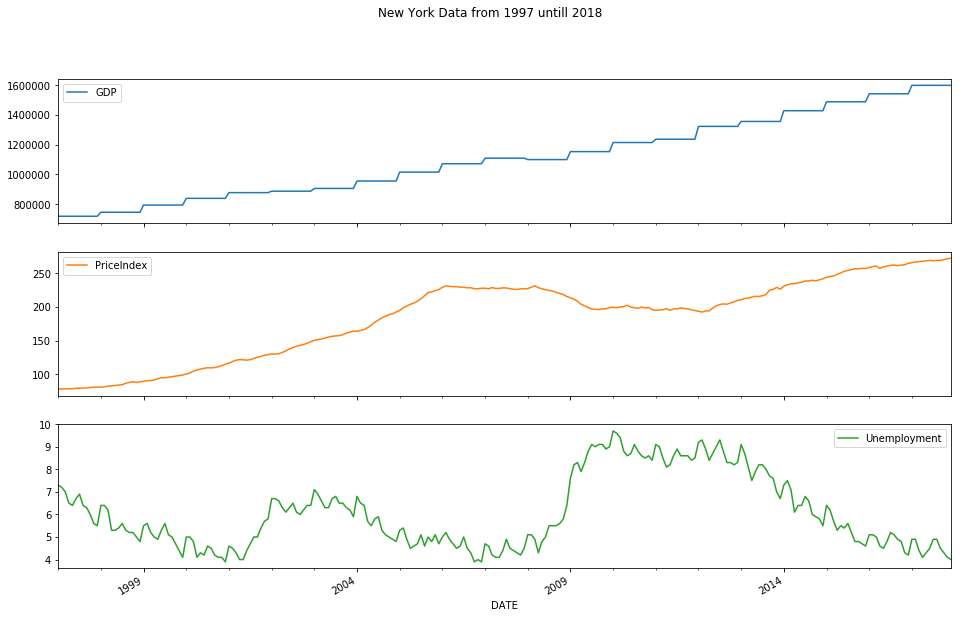

In [8]:
nyc.plot(subplots = True, figsize=(16,10), legend = True, title = "New York Data from 1997 untill 2018");

The above plot shows:

|Name|Trend|Seasonality|
|:----|-----|-----------|
|GDP|upwards|none|
|Prices|upwards|none|
|Unemployment|steady|yearly|

# Feature Engineering

## Stationarity

As shown in the previous section, there are Trends and Seasonality that have to be dealt with.
In order to remove trends and seasonality, the data needs to be transformed further. The goal is to make each series stationary.

Dickey-Fuller-Test is used to determine how stationary a series is. The critical value here is the p-value. If it is less than the confidence level of 0.05 we consider the series to be stationary.

### GDP

In [9]:
from functions import eval_stationary

p-value for Dickey-Fuller test: 0.995
Series is stationary?: No


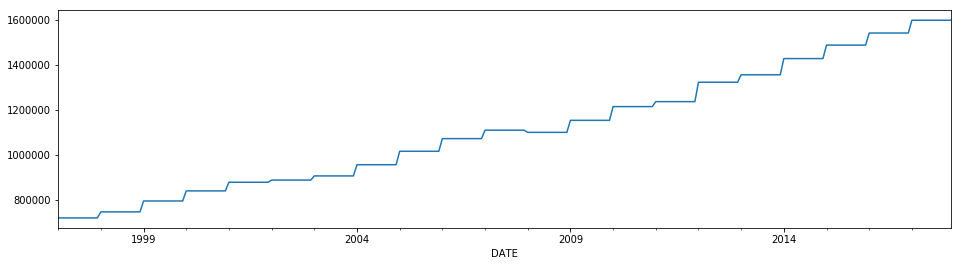

In [10]:
#original Value for the GDP column:
nyc["GDP"].plot(figsize=(16,4));
eval_stationary(nyc["GDP"])

p-value for Dickey-Fuller test: 0.013
Series is stationary?: Yes


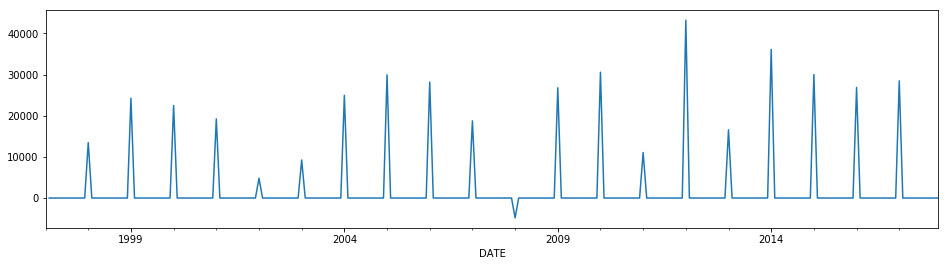

In [11]:
#applying rolling mean
window = 2
new_name = "GDP"+"_roll_"+ str(window)
nyc[new_name] = nyc["GDP"] - nyc["GDP"].rolling(window = window).mean()
eval_stationary(nyc[new_name])

#plot result
nyc[new_name].plot(figsize=(16,4));

### Casey Shiller Index (CSI)

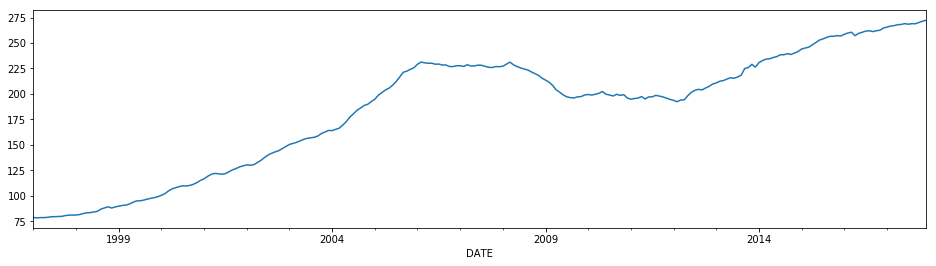

p-value for Dickey-Fuller test: 0.627
Series is stationary?: No
p-value for Dickey-Fuller test: 0.01
Series is stationary?: Yes


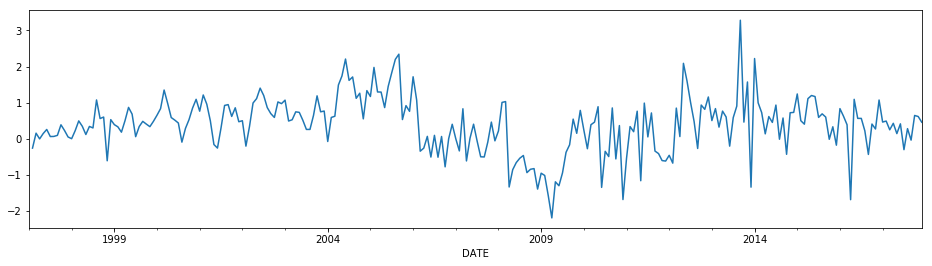

In [12]:
nyc["PriceIndex"].plot(figsize=(16,4));
plt.show()
eval_stationary(nyc["PriceIndex"])

#applying rolling mean
window = 2
new_name = "PriceIndex"+"_roll_"+ str(window)
nyc[new_name] = nyc["PriceIndex"] - nyc["PriceIndex"].rolling(window = window).mean()

#plot result
nyc[new_name].plot(figsize=(16,4));
eval_stationary(nyc[new_name])

### Unemployment rate

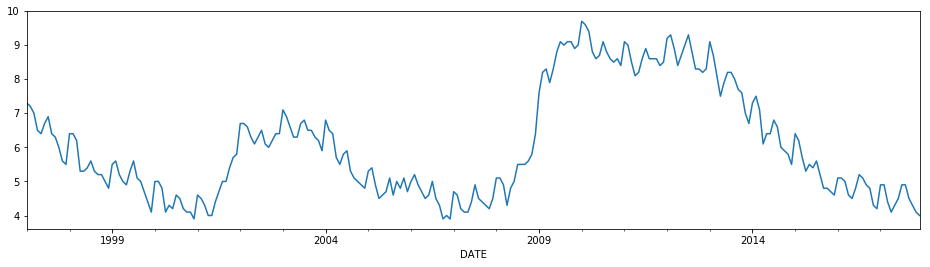

p-value for Dickey-Fuller test: 0.071
Series is stationary?: No
p-value for Dickey-Fuller test: 0.038
Series is stationary?: Yes


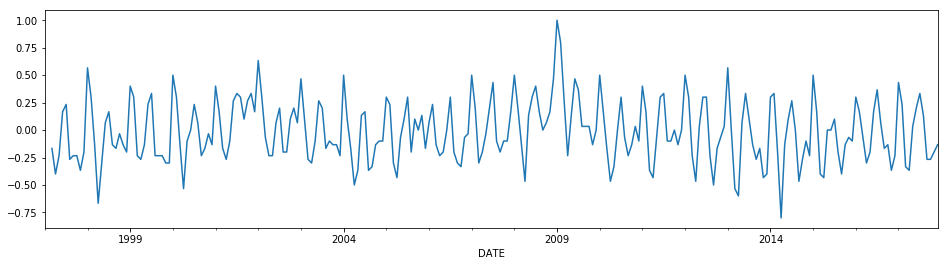

In [13]:
nyc["Unemployment"].plot(figsize=(16,4));
plt.show()
eval_stationary(nyc["Unemployment"])

#applying rolling mean
window = 3
new_name = "Unemployment"+"_roll_"+ str(window)
nyc[new_name] = nyc["Unemployment"] - nyc["Unemployment"].rolling(window = window).mean()

#plot result
nyc[new_name].plot(figsize=(16,4));
eval_stationary(nyc[new_name])

## Train Test Split

In [77]:
#perform a 80/20 train test split
import math
split = math.floor(len(nyc)*0.8)
end = len(nyc)

In [78]:
target = "PriceIndex"
X_train = nyc.copy().dropna().iloc[:split]
X_test = nyc.copy().dropna().iloc[split:]
y_train = None
y_test = None

## Feature Correlation

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index)
#X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

In [81]:
list(nyc.columns)

['GDP',
 'PriceIndex',
 'Unemployment',
 'GDP_roll_2',
 'PriceIndex_roll_2',
 'Unemployment_roll_3']

In [82]:
plot_df = X_train[['GDP_roll_2',
               'PriceIndex_roll_2',
               'Unemployment_roll_3']]

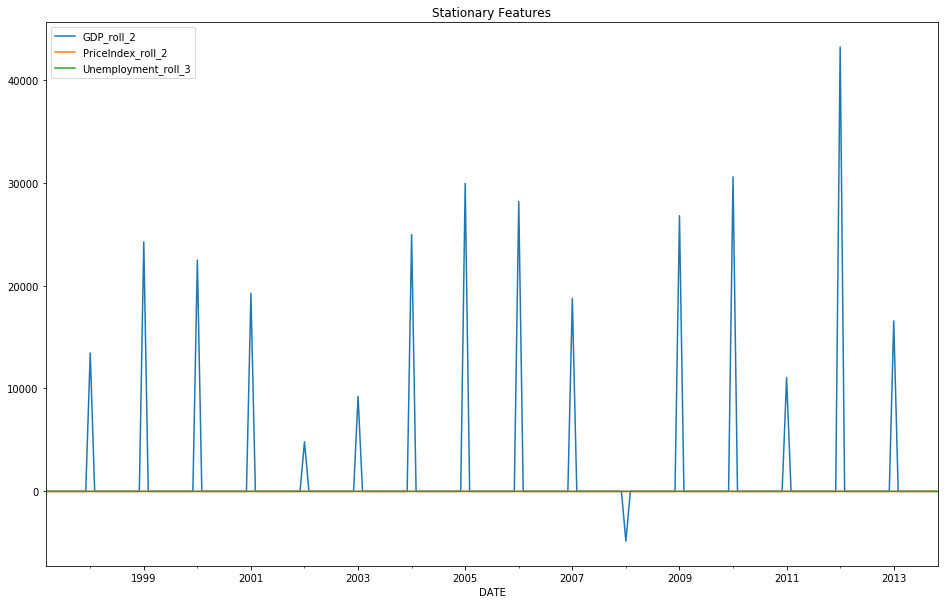

In [83]:
plot_df.plot(subplots = False, figsize=(16,10), title = "Stationary Features");

In [84]:
plot_df.corr()

,GDP_roll_2,PriceIndex_roll_2,Unemployment_roll_3
GDP_roll_2,1.000000,-0.023843,0.428685
PriceIndex_roll_2,-0.023843,1.000000,-0.172707
Unemployment_roll_3,0.428685,-0.172707,1.000000


## Autocorrelation

for col in plot_df.columns:
    plt.figure( figsize = (16,6))
    plt.title(f"Autocorrelation of {col}")
    pd.plotting.autocorrelation_plot(plot_df[col]);
    plt.show()

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

GDP_roll_2
PriceIndex_roll_2
Unemployment_roll_3


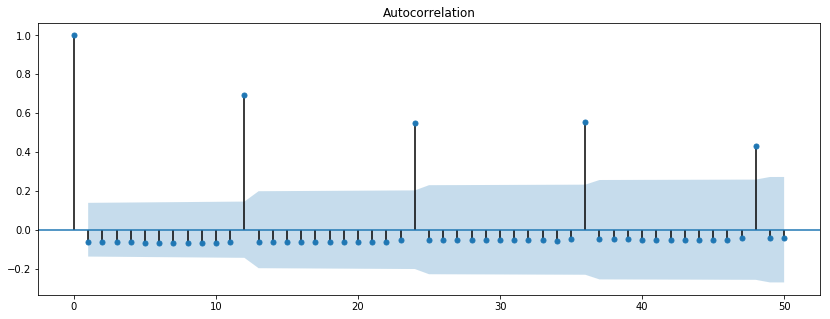

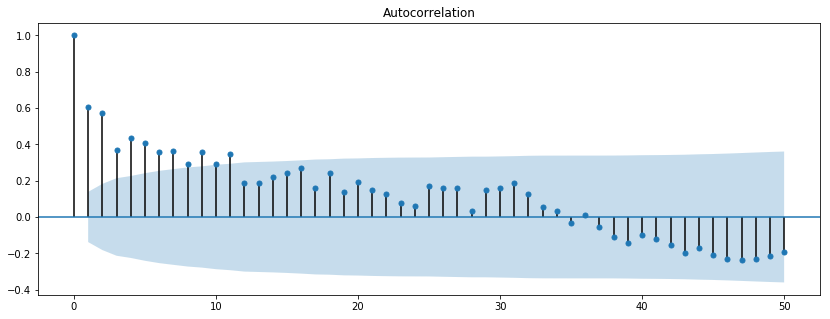

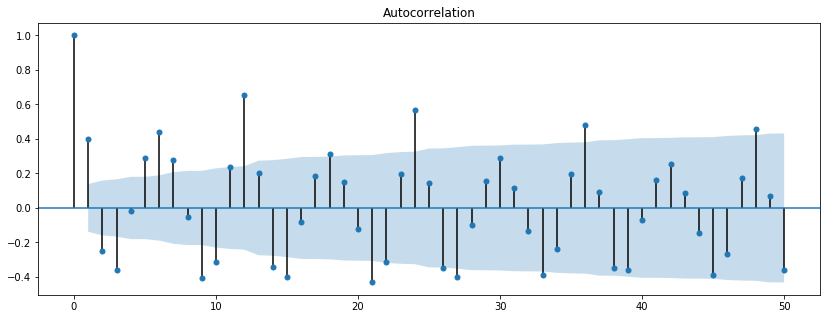

In [86]:
rcParams['figure.figsize'] = 14, 5

for col in plot_df.columns:
    print(col)
    plot_acf(plot_df[col],lags=50);

GDP_roll_2
PriceIndex_roll_2
Unemployment_roll_3


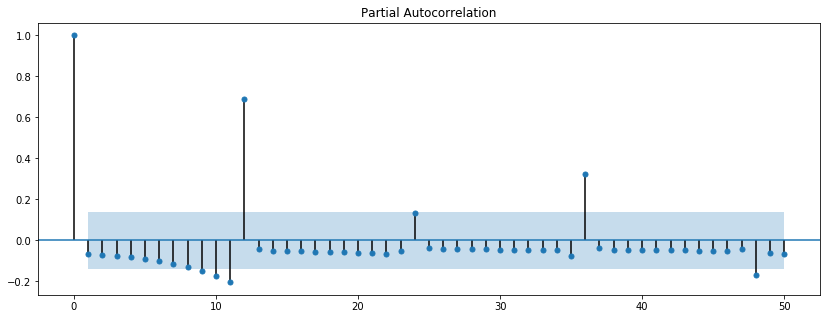

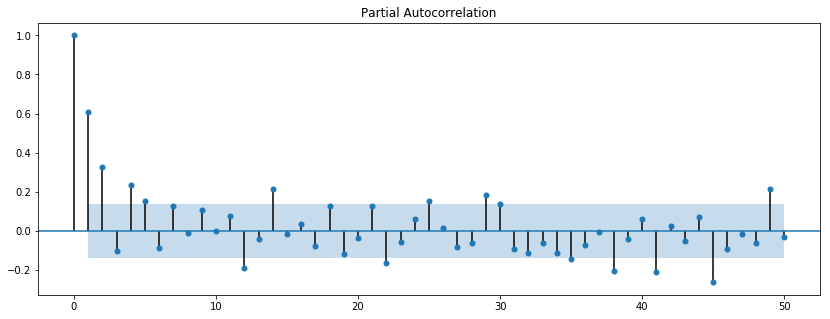

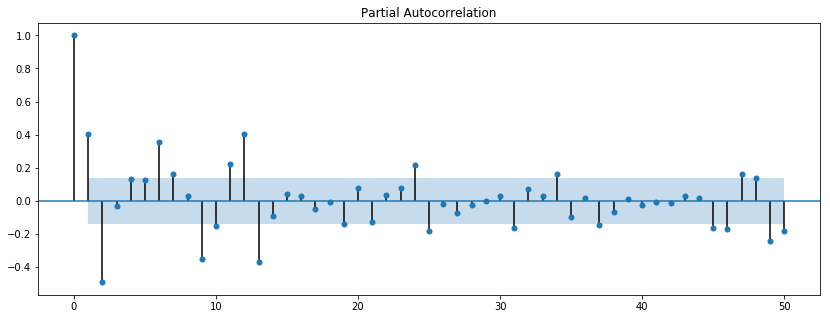

In [87]:
for col in plot_df.columns:
    print(col)
    plot_pacf(plot_df[col],lags=50);

# Feature Selection

In [88]:
nyc.corr()

,GDP,PriceIndex,Unemployment,GDP_roll_2,PriceIndex_roll_2,Unemployment_roll_3
GDP,1.000000,0.893678,0.167239,0.072217,-0.064235,-0.023837
PriceIndex,0.893678,1.000000,0.013045,0.037221,-0.071678,0.005524
Unemployment,0.167239,0.013045,1.000000,0.095881,-0.146513,0.168234
GDP_roll_2,0.072217,0.037221,0.095881,1.000000,0.060954,0.430141
PriceIndex_roll_2,-0.064235,-0.071678,-0.146513,0.060954,1.000000,-0.099836
Unemployment_roll_3,-0.023837,0.005524,0.168234,0.430141,-0.099836,1.000000


# Modeling

For forecasting the future CSI movement the following models will be tested:
+ ARIMA
+ SARIMA
+ multivariant ARIMA

After each test model performance is evaluated by ________ and ultimately a final model is chosen.

## ARIMA

In [89]:
import statsmodels.api as sm
import sklearn.metrics as metrics

In [90]:
model_df = X_train.copy()
fore_cast_span = end-split

`order = (p , d, q)`
+ p = #autoregressive degrees --> auto regression plot (where most extreme)
+ d = nonseasonal differences --> amount of differences
+ q = lagged forecast errors --> amount if difference where the error is compute`

/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


RMSE for Model-Forecast : 0.18


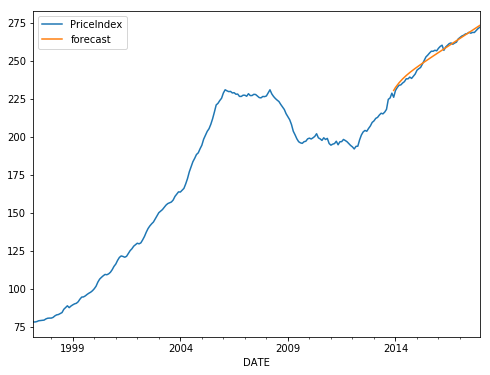

In [91]:
#fit the model
mod = sm.tsa.ARIMA(model_df[target],order=(2,1,0), dates=model_df.index)
res = mod.fit()

#predict
forecast = pd.concat([X_train,X_test], axis = 0)
forecast['forecast'] = res.predict(start = split, end= end, dynamic=True, typ='levels')  

#evaluate
y_pred = forecast.dropna()["forecast"]
y_true = forecast.dropna()[target]
RMSE = round(np.sqrt(metrics.mean_squared_error(y_pred, y_true))/y_true.std(),3)

#plot
forecast[[target, 'forecast']].plot(figsize=(8, 6))
print(f"RMSE for Model-Forecast : {RMSE}")

In [92]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.PriceIndex   No. Observations:                  200
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -321.149
Method:                       css-mle   S.D. of innovations              1.203
Date:                Fri, 12 Jul 2019   AIC                            650.298
Time:                        12:55:25   BIC                            663.491
Sample:                    04-01-1997   HQIC                           655.637
                         - 11-01-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7720      0.313      2.465      0.015       0.158       1.386
ar.L1.D.PriceIndex     0.4137      0.067      6.156      0.000       0.282       0.545
ar.L2.D.PriceIndex     0.3198      0.067      4.761      0.000       0.188       0.451
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2361           +0.0000j            1.2361            0.0000
AR.2           -2.5297           +0.0000j            2.5297            0.5000
-----------------------------------------------------------------------------
"""

## ARIMA with Exog

/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


RMSE for Model-Forecast : 0.225 standard derivations


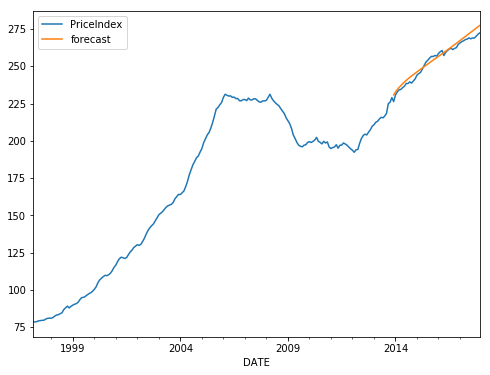

In [93]:
#define exog
exogs = ["Unemployment"]
if exogs:
    exog = X_train[exogs]

#fit the model
mod = sm.tsa.ARIMA(model_df[target],order=(2,1,0), dates=model_df.index, exog=exog)
res = mod.fit()

#predict
forecast = pd.concat([X_train,X_test], axis = 0)
forecast['forecast'] = res.predict(start = split, end= end, dynamic=True, typ='levels', exog=exog)  

#evaluate
y_pred = forecast.dropna()["forecast"]
y_true = forecast.dropna()[target]
RMSE = round(np.sqrt(metrics.mean_squared_error(y_pred, y_true))/y_true.std(),3)

#plot
forecast[[target, 'forecast']].plot(figsize=(8, 6))
print(f"RMSE for Model-Forecast : {RMSE} standard derivations")

In [94]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.PriceIndex   No. Observations:                  200
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -321.024
Method:                       css-mle   S.D. of innovations              1.203
Date:                Fri, 12 Jul 2019   AIC                            652.049
Time:                        12:55:41   BIC                            668.540
Sample:                    04-01-1997   HQIC                           658.723
                         - 11-01-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2422      0.977      1.271      0.205      -0.673       3.158
Unemployment          -0.0751      0.148     -0.506      0.613      -0.366       0.215
ar.L1.D.PriceIndex     0.4100      0.068      6.073      0.000       0.278       0.542
ar.L2.D.PriceIndex     0.3159      0.068      4.675      0.000       0.183       0.448
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2449           +0.0000j            1.2449            0.0000
AR.2           -2.5427           +0.0000j            2.5427            0.5000
-----------------------------------------------------------------------------
"""